## First graph of known convergent antibodies
- V_call: IGHV1-58
- J_call: IGHJ3
- junction_aa length: 18 (amino acids)
- Chosen individuals (data files): 
    - Didn't find V_call = IGHV1-58 in the named files.

In [1]:
import numpy as np
import pandas as pd
from Levenshtein import distance
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


### Data Processing

In [5]:
# --- read in --- #
a_d11_clone_pass = pd.read_csv("data/IGHV3_53/A_d11__clone-pass.tsv", sep = '\t')
b_d10_clone_pass = pd.read_csv("data/IGHV3_53/B_d10__clone-pass.tsv", sep = '\t')
c_d15_clone_pass = pd.read_csv("data/IGHV3_53/C_d15__clone-pass.tsv", sep = "\t")
d_d28_clone_pass = pd.read_csv("data/IGHV3_53/D_d28__clone-pass.tsv", sep = "\t")
e_d44_clone_pass = pd.read_csv("data/IGHV3_53/E_d44__clone-pass.tsv", sep = "\t")
f_d14_clone_pass = pd.read_csv("data/IGHV3_53/F_d14__clone-pass.tsv", sep = "\t")
g_d22_clone_pass = pd.read_csv("data/IGHV3_53/G_d22__clone-pass.tsv", sep = "\t")
test = pd.read_csv("data/IGHV3_53/Pt-2-3__clone-pass.tsv", sep = "\t")



In [143]:
g_d22_clone_pass["v_call"].unique()

array(['IGHV3-53*04,IGHV3-53*06', 'IGHV3-53*01,IGHV3-53*02',
       'IGHV3-53*05', 'IGHV3-53*01,IGHV3-53*02,IGHV3-53*05',
       'IGHV3-53*05,IGHV3-66*02', 'IGHV3-53*05,IGHV3-66*02,IGHV3-66*03',
       'IGHV3-53*01,IGHV3-53*02,IGHV3-66*01', 'IGHV3-53*03'], dtype=object)

In [152]:
# --- filtering --- #
# - parameters
target_junction_length = 54

# - select columns
a_d11_data = a_d11_clone_pass[["sequence_id", "v_call", "j_call", "junction_aa", "junction_length", "single_cell"]] # 1741 rows
b_d10_data = test[["sequence_id", "v_call", "j_call", "junction_aa", "junction_length", "single_cell"]] # 558 rows

# print(len(b_d10_data))

# - add individual label
a_d11_data.insert(loc = 0, column = "individual", value = "a_d11")
b_d10_data.insert(loc = 0, column = "individual", value = "b_d10")

# - filter length and single cell = False
a_d11_data = a_d11_data.loc[(a_d11_data["junction_length"] == target_junction_length) & (a_d11_data["single_cell"] == False)] # 121 rows
b_d10_data = b_d10_data.loc[(b_d10_data["junction_length"] == target_junction_length) & (b_d10_data["single_cell"] == False)] # 44 rows

# - filter v_call, j_call (TO IMPLEMENT IF WANT)
# will need comma separation

# - drop duplicates 
a_d11_data = a_d11_data.drop_duplicates(subset=['junction_aa'])
b_d10_data = b_d10_data.drop_duplicates(subset=['junction_aa'])

# --- check data --- #
# print(a_d11_data.shape) # 109 rows
# print(b_d10_data.shape) # 34 rows

# a_d11_data.head()

# --- full dataset --- #
full_data = pd.concat([a_d11_data, b_d10_data]) # 143 * 7
full_data = full_data.reset_index(drop=True) # drops previous indexing 

# full_data.head
print(len(full_data))

118


In [148]:
# ----- parameters ----- #
indiv1 = "a_d11" # manual atm; can automate in the future
indiv2 = "b_d10"
indiv1_n = len(full_data[full_data["individual"] == indiv1])
indiv2_n = len(full_data[full_data["individual"] == indiv2])

n = len(full_data) # number of observations (ie. sequenes)
n_indiv = len(full_data["individual"].unique())


### Compute distance + adjacency matrix

In [149]:
# use full_data to access data (index = node label)
# --- create distance matrix --- #
# normalized hamming distance
def hamming_distance_norm_str(str1, str2):
    assert len(str1) == len(str2)
    return sum(c1 != c2 for c1, c2 in zip(str1, str2)) / len(str1)

junction_aa_data = pd.DataFrame(full_data["junction_aa"])

# compute distances
pairwise_distances = pdist(junction_aa_data, lambda x,y: hamming_distance_norm_str(x[0], y[0])) # grab str1 from [str1]
distance_matrix = squareform(pairwise_distances)
# print(distance_matrix.shape) # 143 by 143
# print(type(distance_matrix)) # numpy ndarray

# --- create adjacency matrix --- #
# threshold adjacency matrix - can loop instead
threshold = 6.0/18.0

boolean_matrix = (distance_matrix <= threshold)
adjacency_matrix = boolean_matrix * 1 # boolean to 0/1. 
np.fill_diagonal(adjacency_matrix, 0) # no self-edges
# print(adjacency_matrix)

# average degree of a node
print(np.sum(adjacency_matrix) / (2 * adjacency_matrix.shape[0]))


0.8050847457627118


### Create Graph; add attributes

In [132]:
# --- create graph from adjacency matrix --- #
G = nx.from_numpy_array(adjacency_matrix)

# len(G.nodes) # 143
# len(G.edges) # 115

# --- add in attribute data --- #
# for loop
for i in range(n):
    # add in attributes of individual, sequence
    G.nodes[i]["individual"] = full_data.iloc[i]["individual"]
    G.nodes[i]["junction_aa"] = full_data.iloc[i]["junction_aa"]

# G.nodes.data()

### Analysis

{'a_d11': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'b_d10': (1.0, 0.4980392156862745, 0.054901960784313725)}


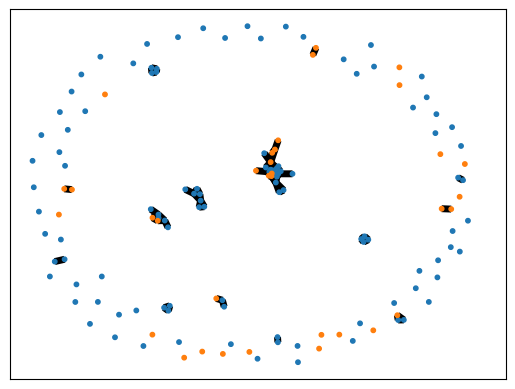

In [136]:
# --- plot basic graph --- #
# nx.draw(G) # just nodes in a circle; can't really see edges
# nx.draw_networkx(G, node_size=20, width=2, with_labels=False)

# --- color points by attribute? either from graph data or external node metadata --- #
# manual colors; can find better way to do this
colors_manual = ["red"] * indiv1_n + ["blue"] * indiv2_n

# seaborn color palette; dictionary mapping
individual_list = full_data["individual"].unique()

rgb_values = sns.color_palette(n_colors = n_indiv)

color_map = dict(zip(individual_list, rgb_values))

full_data["color"] = full_data["individual"].map(color_map)

colors_palette = full_data["color"]

# print(full_data["color"])
print(color_map)

# --- plot graph with customization --- #
nx.draw_networkx(G, node_size=10, width=5, with_labels=False, node_color = colors_palette)

# --- check out other graph python libraries suggested in CPSC 483 notes somewhere --- #

In [134]:
# --- identify sequences with neighbors of both individuals --- #
list_of_intersections = [] # contains sequences that have both individuals as neighbors

for node, neighbors in G.adj.items():
    neighbor_set = set()
    # n_indiv = 2 # defined previously in parameter section

    # loop - can compute statistics for nodes and add them as attributes
    for neighbor, edge_attribute in neighbors.items():
        # print(neighbor) # index (ie. 1, 2, etc.)
        neighbor_set.add(G.nodes[neighbor]["individual"])

    # condition for adding to set we want
    if len(neighbor_set) / n_indiv > 0.5: # rn, requires having neighbors of both individual types
        list_of_intersections.append(G.nodes[node]["junction_aa"])

print(list_of_intersections)


['CARGGYYYDSSGLNFDYW', 'CAREGNYYDSSGYYYGYW', 'CARGWRQRWSDDWYFDLW', 'CARGGGSSGWYHDAFDIW', 'CARDGRGRGGVHDAFDIW', 'CARVNRGSGYYYDAFDIW', 'CARPGNYGPYYYYGMDVW', 'CARVKWNQWHYYYGMDVW', 'CARFPLNVAYYYYGMDVW', 'CARGSGSLVYYYYGMDVW', 'CARGWELLGFYYYGMDVW', 'CARGDGRGGYYYYGMDVW', 'CARRILYEHNYYYGMDVW', 'CAREQWPGENYYYGMDVW', 'CARESSRGYYYYYGMDVW', 'CARGLLWFGEYYYGMDVW', 'CARVSPLGYYYYYGMDVW', 'CARVSNWDYYYYYGMDVW', 'CARYRPQAEYYYYGMDVW', 'CARVRHSSGYYFSAFDIW', 'CARDRRSSGWSNDAFDIW']


In [145]:
for c in nx.connected_components(G):
    if len(c) >= 2:
        print(c)

{0, 1, 2}
{3, 4, 5, 6}
{8, 9}
{11, 12}
{39, 15, 17, 20, 24, 26, 29}
{129, 53, 45}
{114, 59, 60}
{64, 65, 66, 75, 141, 142, 63}
{132, 135, 76, 77, 78, 79, 80, 87, 88, 91, 93, 94, 96, 97, 98, 106, 108, 113, 115, 118, 119, 120, 121}
{84, 95, 102, 103}
{89, 85}
{109, 110}
{112, 116}
{136, 127}
